# 1. Thư viện

## 1.1. Khai báo các thư viện

In [20]:
# Import các thư viện cần thiết
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import seaborn as sns
import joblib
import time

import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

import xgboost
from xgboost import XGBRegressor

## 1.2. Kiểm tra phiên bản các thư viện

In [21]:
# Thông tin phiên bản các thư viện Python
print('Phiên bản Python: {}'.format(sys.version))
print('Phiên bản Numpy: {}'.format(np.__version__))
print('Phiên bản Pandas: {}'.format(pd.__version__))
print('Phiên bản Matplotlib: {}'.format(matplotlib.__version__))
print('Phiên bản Seaborn: {}'.format(sns.__version__))
print('Phiên bản Sci-Kit Learn: {}'.format(sklearn.__version__))
print('Phiên bản XGBoost: {}'.format(xgboost.__version__))

Phiên bản Python: 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]
Phiên bản Numpy: 2.3.1
Phiên bản Pandas: 2.3.0
Phiên bản Matplotlib: 3.10.3
Phiên bản Seaborn: 0.13.2
Phiên bản Sci-Kit Learn: 1.7.0
Phiên bản XGBoost: 3.0.2


# 2. Thu thập và xử lý dữ liệu

## 2.1 Lấy dữ liệu

### 2.1.1 Dữ liệu từ file

#### 2.1.1.1 Drive

In [22]:
# from google.colab import drive

# # Kết nối Google Drive
# drive.mount('/content/drive')

# # Đặt đường dẫn tới thư mục chứa dữ liệu
# data_path = '/content/drive/MyDrive/MHUD/Project/Datasets'

# # Đọc file CSV từ Google Drive như đọc local
# eu = pd.read_csv(f'{data_path}/EURUSD-2000-2020-15m.csv', skipinitialspace=True)

# # Chuẩn hóa cột
# eu.columns = [x.lower() for x in eu.columns]

# # Chuyển đổi cột thời gian
# eu["date_time"] = pd.to_datetime(eu["date_time"], format='%Y.%m.%d %H:%M:%S')
# eu.set_index('date_time', inplace=True)

# # Hiển thị 5 dòng đầu tiên
# eu.head(5)


#### 2.1.1.2 Local

In [23]:
eu = pd.read_csv('./EURUSD-2000-2020-15m.csv', skipinitialspace=True)
eu.columns = [x.lower() for x in eu.columns]
eu["date_time"] = pd.to_datetime(eu["date_time"], format='%Y.%m.%d %H:%M:%S')
eu.set_index('date_time', inplace=True)
eu.head(5)

,high,low,open,close
date_time,,,,
2000-01-03 00:00:00,1.0080,1.0073,1.0073,1.0077
2000-01-03 00:15:00,1.0087,1.0076,1.0078,1.0086
2000-01-03 00:30:00,1.0089,1.0079,1.0087,1.0079
2000-01-03 00:45:00,1.0132,1.0078,1.0078,1.0128
2000-01-03 01:00:00,1.0133,1.0120,1.0129,1.0122


### 2.1.2 Trực quan hóa dữ liệu

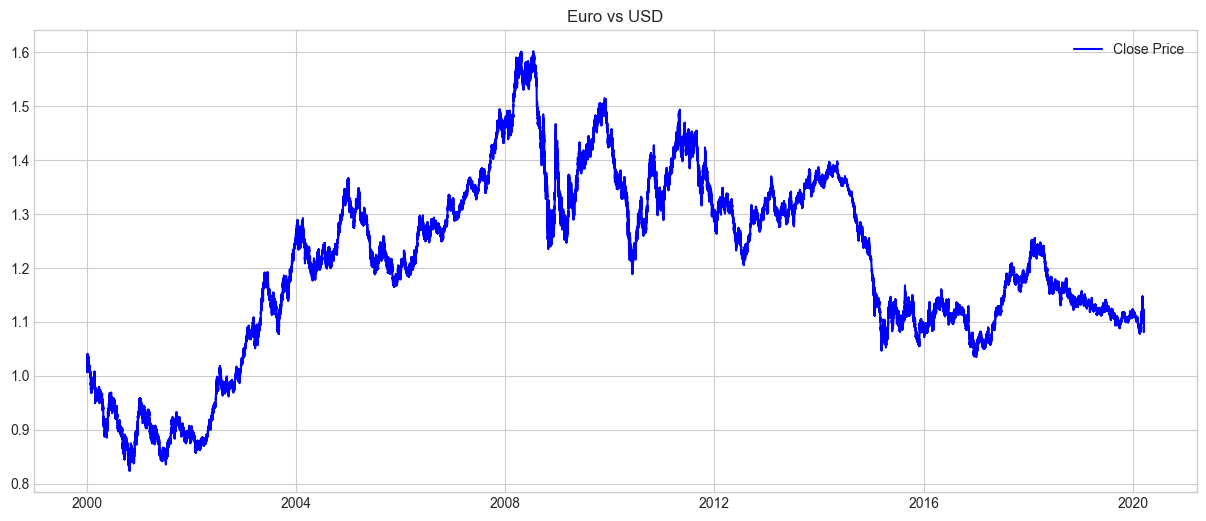

<Axes: >

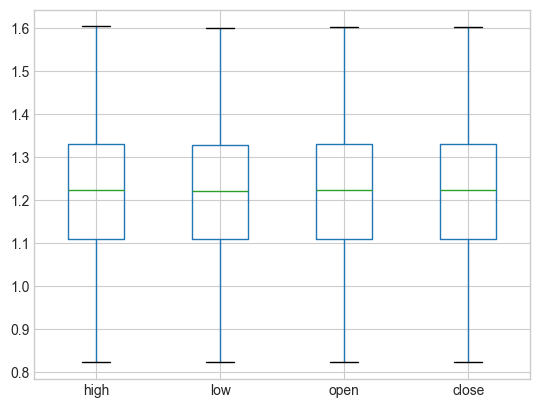

In [24]:
plt.figure(figsize=(15,6))
plt.plot(eu.close, label='Close Price', color='blue')
plt.title('Euro vs USD')
plt.legend()
plt.show()

# Biểu đồ box plot cho open, high, low, close
eu.boxplot()

### 2.1.3 Tạo các đặc trưng mới

In [25]:
def generate_features(df):
    """ Tạo các đặc trưng cho cổ phiếu/chỉ số/tiền tệ/hàng hóa dựa trên giá lịch sử và hiệu suất
    Args:
        df (dataframe với các cột "open", "close", "high", "low")
    Returns:
        dataframe, tập dữ liệu với các đặc trưng mới
    """
    df_new = pd.DataFrame()

    # 6 đặc trưng gốc
    df_new['open'] = df['open']
    df_new['open_1'] = df['open'].shift(1)
    df_new['close_1'] = df['close'].shift(1)
    df_new['high_1'] = df['high'].shift(1)
    df_new['low_1'] = df['low'].shift(1)

    # 50 đặc trưng gốc
    # giá trung bình
    df_new['avg_price_5'] = df['close'].rolling(window=5).mean().shift(1)
    df_new['avg_price_30'] = df['close'].rolling(window=21).mean().shift(1)
    df_new['avg_price_90'] = df['close'].rolling(window=63).mean().shift(1)
    df_new['avg_price_365'] = df['close'].rolling(window=252).mean().shift(1)

    # tỷ lệ giá trung bình
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_905_'] = df_new['avg_price_5'] / df_new['avg_price_90']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_90'] = df_new['avg_price_30'] / df_new['avg_price_90']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    df_new['ratio_avg_price_90_365'] = df_new['avg_price_90'] / df_new['avg_price_365']

    # độ lệch chuẩn của giá
    df_new['std_price_5'] = df['close'].rolling(window=5).std().shift(1)
    df_new['std_price_30'] = df['close'].rolling(window=21).std().shift(1)
    df_new['std_price_90'] = df['close'].rolling(window=63).std().shift(1)
    df_new['std_price_365'] = df['close'].rolling(window=252).std().shift(1)

    # tỷ lệ độ lệch chuẩn của giá
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_90'] = df_new['std_price_5'] / df_new['std_price_90']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_90'] = df_new['std_price_30'] / df_new['std_price_90']
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']
    df_new['ratio_std_price_90_365'] = df_new['std_price_90'] / df_new['std_price_365']

    # lợi nhuận
    df_new['return_1'] = ((df['close'] - df['close'].shift(1)) / df['close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['close'] - df['close'].shift(5)) / df['close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['close'] - df['close'].shift(21)) / df['close'].shift(21)).shift(1)
    df_new['return_90'] = ((df['close'] - df['close'].shift(63)) / df['close'].shift(63)).shift(1)
    df_new['return_365'] = ((df['close'] - df['close'].shift(252)) / df['close'].shift(252)).shift(1)

    # trung bình lợi nhuận
    df_new['moving_avg_5'] = df_new['return_1'].rolling(window=5).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=21).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=63).mean()
    df_new['moving_avg_365'] = df_new['return_1'].rolling(window=252).mean()

    # RSI (Relative Strength Index)
    for n in [7, 14, 21]:
        delta = df['close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        avg_gain = gain.rolling(window=n).mean().shift(1)
        avg_loss = loss.rolling(window=n).mean().shift(1)

        rs = avg_gain / avg_loss
        df_new[f'rsi_{n}'] = 100 - (100 / (1 + rs))

    # Stochastic Oscillator
    for n in [5, 14, 21]:
        low_n = df['low'].rolling(window=n).min().shift(1)
        high_n = df['high'].rolling(window=n).max().shift(1)

        # %K
        df_new[f'stoch_k_{n}'] = 100 * ((df['close'].shift(1) - low_n) / (high_n - low_n))
        # %D (Trung bình động đơn giản của %K)
        df_new[f'stoch_d_{n}'] = df_new[f'stoch_k_{n}'].rolling(window=3).mean()

    # Bollinger Bands
    for n in [10, 20, 50]:
        # Middle Band
        middle_band = df['close'].rolling(window=n).mean().shift(1)
        # Standard Deviation
        std_dev = df['close'].rolling(window=n).std().shift(1)

        # Upper and Lower Bands
        df_new[f'bollinger_upper_{n}'] = middle_band + (std_dev * 2)
        df_new[f'bollinger_lower_{n}'] = middle_band - (std_dev * 2)

    # MACD
    # Cấu hình chuẩn (12, 26)
    ema_fast = df['close'].ewm(span=12, adjust=False).mean()
    ema_slow = df['close'].ewm(span=26, adjust=False).mean()
    df_new['macd_12_26'] = (ema_fast - ema_slow).shift(1)
    df_new['macd_signal_12_26'] = df_new['macd_12_26'].ewm(span=9, adjust=False).mean()

    # Cấu hình thay thế (5, 35)
    ema_fast_alt = df['close'].ewm(span=5, adjust=False).mean()
    ema_slow_alt = df['close'].ewm(span=35, adjust=False).mean()
    df_new['macd_5_35'] = (ema_fast_alt - ema_slow_alt).shift(1)
    df_new['macd_signal_5_35'] = df_new['macd_5_35'].ewm(span=5, adjust=False).mean()

    # biến mục tiêu
    df_new['close'] = df['close']
    df_new = df_new.dropna(axis=0)
    return df_new

data = generate_features(eu)

### 2.1.4 Kiểm tra dữ liệu đã sử lý

Các thông tin cơ bản của dữ liệu

In [26]:
print(f"Kích thước dữ liệu: {data.shape}")
print(f"Khoảng thời gian: {data.index.min()} đến {data.index.max()}")
print(f"Các features: {list(data.columns)}")

data.info()

Kích thước dữ liệu: (500496, 53)
Khoảng thời gian: 2000-01-05 15:45:00 đến 2020-03-19 06:00:00
Các features: ['open', 'open_1', 'close_1', 'high_1', 'low_1', 'avg_price_5', 'avg_price_30', 'avg_price_90', 'avg_price_365', 'ratio_avg_price_5_30', 'ratio_avg_price_905_', 'ratio_avg_price_5_365', 'ratio_avg_price_30_90', 'ratio_avg_price_30_365', 'ratio_avg_price_90_365', 'std_price_5', 'std_price_30', 'std_price_90', 'std_price_365', 'ratio_std_price_5_30', 'ratio_std_price_5_90', 'ratio_std_price_5_365', 'ratio_std_price_30_90', 'ratio_std_price_30_365', 'ratio_std_price_90_365', 'return_1', 'return_5', 'return_30', 'return_90', 'return_365', 'moving_avg_5', 'moving_avg_30', 'moving_avg_365', 'rsi_7', 'rsi_14', 'rsi_21', 'stoch_k_5', 'stoch_d_5', 'stoch_k_14', 'stoch_d_14', 'stoch_k_21', 'stoch_d_21', 'bollinger_upper_10', 'bollinger_lower_10', 'bollinger_upper_20', 'bollinger_lower_20', 'bollinger_upper_50', 'bollinger_lower_50', 'macd_12_26', 'macd_signal_12_26', 'macd_5_35', 'macd_si

Ma trận heat map của tập dữ liệu


Biểu đồ nhiệt



<Axes: >

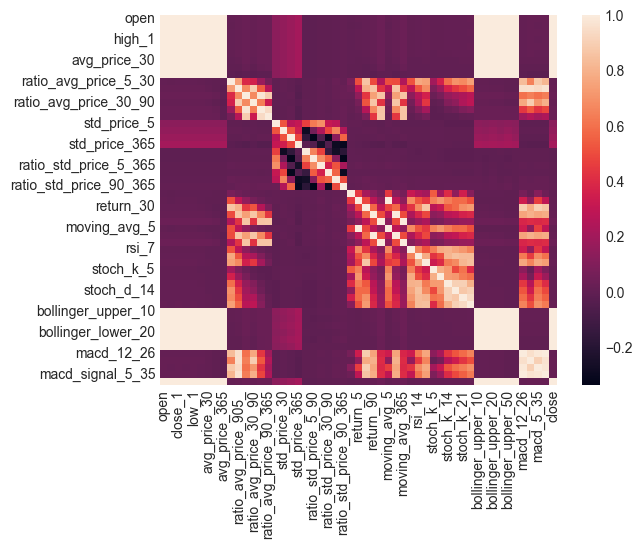

In [27]:
data.head()

data.describe()
print("\nBiểu đồ nhiệt\n")
sns.heatmap(data.corr())

## 2.2 Chia dữ liệu

### 2.2.1 Hold-out

In [28]:
# import thư viện datetime
import datetime

# phân chia dữ liệu cho training
start_train = datetime.datetime(2000, 1, 1,0,0)
end_train = datetime.datetime(2018, 12, 31, 0, 0)
data_train = data.loc[start_train:end_train]
data_train.describe()


# phân chia dữ liệu cho testing
start_test = datetime.datetime(2019, 1, 1, 0, 0)
data_test = data.loc[start_test:]
data_test.describe()

,open,open_1,close_1,high_1,low_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,...,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,bollinger_upper_50,bollinger_lower_50,macd_12_26,macd_signal_12_26,macd_5_35,macd_signal_5_35,close
count,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,...,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000
mean,1.116983,1.116985,1.116983,1.117242,1.116720,1.116987,1.117001,1.117039,1.117179,0.999987,...,1.116163,1.118161,1.115839,1.118889,1.115165,-0.000013,-0.000012,-0.000027,-0.000027,1.116981
std,0.014744,0.014744,0.014744,0.014767,0.014723,0.014739,0.014724,0.014685,0.014557,0.000752,...,0.014687,0.014856,0.014669,0.014915,0.014635,0.000463,0.000435,0.000969,0.000936,0.014744
min,1.078360,1.078360,1.078390,1.078500,1.077780,1.078474,1.078739,1.079089,1.079644,0.992224,...,1.077641,1.079101,1.077174,1.079544,1.076668,-0.004502,-0.003855,-0.010116,-0.009146,1.078390
25%,1.106910,1.106920,1.106910,1.107190,1.106670,1.106944,1.106933,1.106939,1.106912,0.999702,...,1.106215,1.107896,1.105815,1.108477,1.105191,-0.000204,-0.000196,-0.000430,-0.000422,1.106910
50%,1.116420,1.116420,1.116410,1.116640,1.116150,1.116400,1.116313,1.116134,1.116486,1.000003,...,1.115559,1.117621,1.115236,1.118304,1.114604,-0.000005,-0.000005,-0.000017,-0.000015,1.116410
75%,1.127890,1.127890,1.127890,1.128150,1.127630,1.127876,1.127883,1.127999,1.128148,1.000280,...,1.127089,1.129021,1.126773,1.129876,1.125812,0.000181,0.000173,0.000377,0.000368,1.127890
max,1.156910,1.156910,1.156910,1.156970,1.156440,1.156522,1.155808,1.154907,1.151470,1.005555,...,1.155294,1.157116,1.154785,1.159111,1.153916,0.002600,0.002206,0.006225,0.005218,1.156910


### 2.2.2 Time Series Cross-Validation

Time Series Cross-Validation là phương pháp chia dữ liệu phù hợp với dữ liệu chuỗi thời gian, đảm bảo không sử dụng dữ liệu tương lai để dự đoán quá khứ.

Time Series Cross-Validation với 5 folds:
Fold 1: Train = 83416 mẫu, Test = 83416 mẫu
  Train: từ 0 đến 83415
  Test: từ 83416 đến 166831
Fold 2: Train = 166832 mẫu, Test = 83416 mẫu
  Train: từ 0 đến 166831
  Test: từ 166832 đến 250247
Fold 3: Train = 250248 mẫu, Test = 83416 mẫu
  Train: từ 0 đến 250247
  Test: từ 250248 đến 333663
Fold 4: Train = 333664 mẫu, Test = 83416 mẫu
  Train: từ 0 đến 333663
  Test: từ 333664 đến 417079
Fold 5: Train = 417080 mẫu, Test = 83416 mẫu
  Train: từ 0 đến 417079
  Test: từ 417080 đến 500495


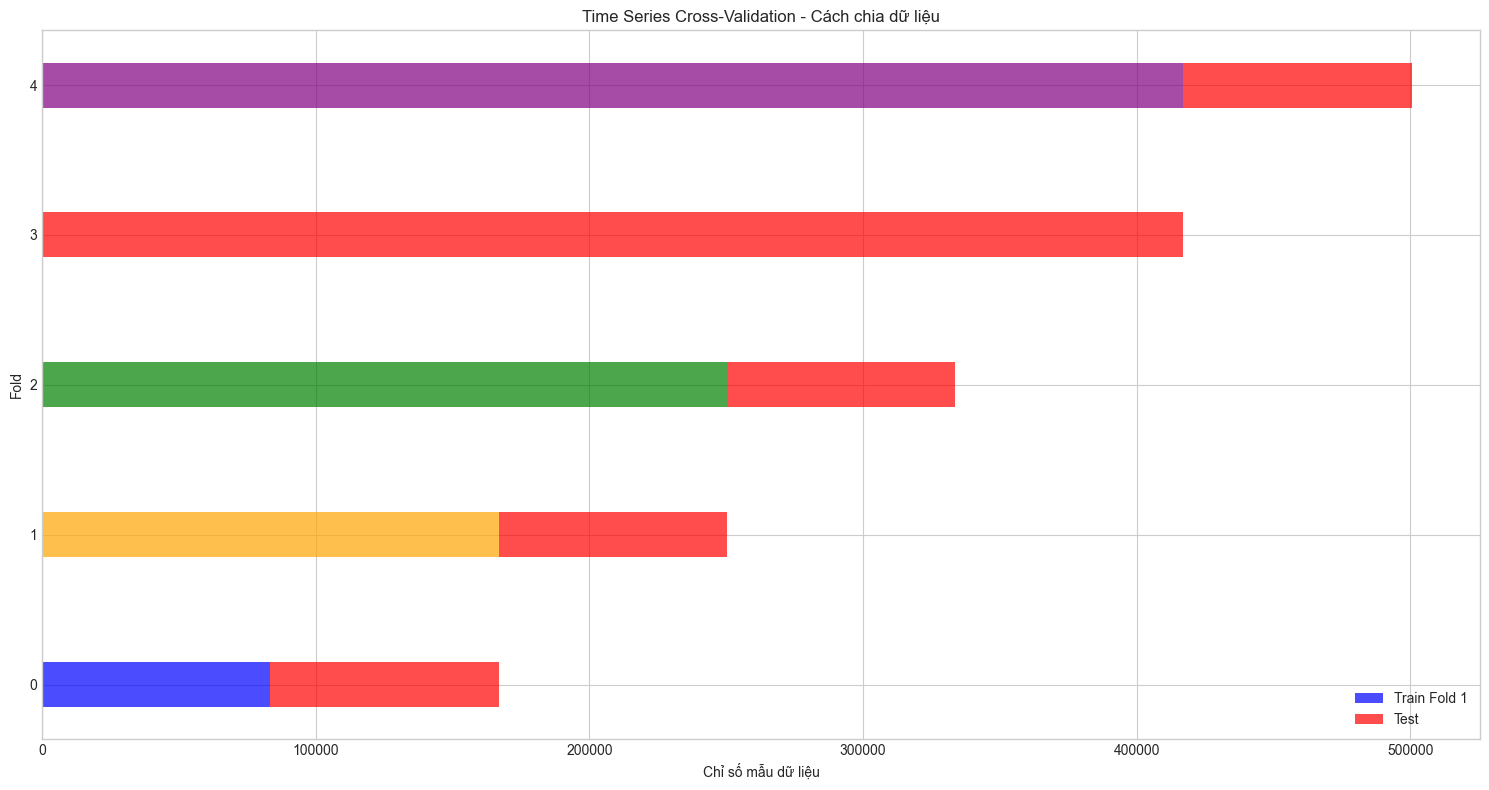


Ưu điểm của Time Series CV:
- Không sử dụng dữ liệu tương lai để dự đoán quá khứ
- Mô phỏng thực tế việc dự đoán theo thời gian
- Đánh giá độ ổn định của mô hình qua thời gian


In [29]:
from sklearn.model_selection import TimeSeriesSplit

# Thiết lập Time Series Cross-Validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Hiển thị cách chia dữ liệu
print(f"Time Series Cross-Validation với {n_splits} folds:")
print("="*60)

fig, ax = plt.subplots(figsize=(15, 8))
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Lấy dữ liệu để minh họa
X_demo = data.drop('close', axis='columns')
y_demo = data['close']

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_demo)):
    # Vẽ train set
    ax.barh(fold, len(train_idx), left=train_idx[0], height=0.3, 
            color=colors[fold], alpha=0.7, label=f'Train Fold {fold+1}' if fold == 0 else "")
    
    # Vẽ test set
    ax.barh(fold, len(test_idx), left=test_idx[0], height=0.3, 
            color='red', alpha=0.7, label='Test' if fold == 0 else "")
    
    print(f"Fold {fold+1}: Train = {len(train_idx)} mẫu, Test = {len(test_idx)} mẫu")
    print(f"  Train: từ {train_idx[0]} đến {train_idx[-1]}")
    print(f"  Test: từ {test_idx[0]} đến {test_idx[-1]}")

ax.set_xlabel('Chỉ số mẫu dữ liệu')
ax.set_ylabel('Fold')
ax.set_title('Time Series Cross-Validation - Cách chia dữ liệu')
ax.legend()
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Ưu điểm của Time Series CV:")
print("- Không sử dụng dữ liệu tương lai để dự đoán quá khứ")
print("- Mô phỏng thực tế việc dự đoán theo thời gian")
print("- Đánh giá độ ổn định của mô hình qua thời gian")


## 2.3 Chuẩn hóa dữ liệu

### 2.3.1 Chuẩn hóa dữ liệu cho Holdout

In [30]:
#lấy thuộc tính close cho train và test
X_train = data_train.drop('close', axis='columns')
y_train = data_train['close']

X_test = data_test.drop('close', axis='columns')
y_test = data_test['close']

# chuẩn hóa scaling
scaler = StandardScaler()

X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

# hiển thị lại dữ liệu
data_test.describe()

,open,open_1,close_1,high_1,low_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,...,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,bollinger_upper_50,bollinger_lower_50,macd_12_26,macd_signal_12_26,macd_5_35,macd_signal_5_35,close
count,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,...,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000
mean,1.116983,1.116985,1.116983,1.117242,1.116720,1.116987,1.117001,1.117039,1.117179,0.999987,...,1.116163,1.118161,1.115839,1.118889,1.115165,-0.000013,-0.000012,-0.000027,-0.000027,1.116981
std,0.014744,0.014744,0.014744,0.014767,0.014723,0.014739,0.014724,0.014685,0.014557,0.000752,...,0.014687,0.014856,0.014669,0.014915,0.014635,0.000463,0.000435,0.000969,0.000936,0.014744
min,1.078360,1.078360,1.078390,1.078500,1.077780,1.078474,1.078739,1.079089,1.079644,0.992224,...,1.077641,1.079101,1.077174,1.079544,1.076668,-0.004502,-0.003855,-0.010116,-0.009146,1.078390
25%,1.106910,1.106920,1.106910,1.107190,1.106670,1.106944,1.106933,1.106939,1.106912,0.999702,...,1.106215,1.107896,1.105815,1.108477,1.105191,-0.000204,-0.000196,-0.000430,-0.000422,1.106910
50%,1.116420,1.116420,1.116410,1.116640,1.116150,1.116400,1.116313,1.116134,1.116486,1.000003,...,1.115559,1.117621,1.115236,1.118304,1.114604,-0.000005,-0.000005,-0.000017,-0.000015,1.116410
75%,1.127890,1.127890,1.127890,1.128150,1.127630,1.127876,1.127883,1.127999,1.128148,1.000280,...,1.127089,1.129021,1.126773,1.129876,1.125812,0.000181,0.000173,0.000377,0.000368,1.127890
max,1.156910,1.156910,1.156910,1.156970,1.156440,1.156522,1.155808,1.154907,1.151470,1.005555,...,1.155294,1.157116,1.154785,1.159111,1.153916,0.002600,0.002206,0.006225,0.005218,1.156910


### 2.3.2 Chuẩn hóa dữ liệu cho Time Series CV

Trong Time Series Cross-Validation, việc chuẩn hóa dữ liệu cần được thực hiện riêng biệt cho từng fold để tránh data leakage. Mỗi fold sẽ có scaler riêng được fit trên training set của fold đó.

In [31]:
# Dữ liệu đầy đủ (toàn bộ dataset)
X_full = data.drop('close', axis='columns')
y_full = data['close']

print(f"📊 Thông tin dữ liệu đầy đủ:")
print(f"   • Số mẫu: {X_full.shape[0]:,}")
print(f"   • Số features: {X_full.shape[1]}")
print(f"   • Khoảng thời gian: {X_full.index.min()} đến {X_full.index.max()}")
print(f"   • Tần suất: 15 phút")


📊 Thông tin dữ liệu đầy đủ:
   • Số mẫu: 500,496
   • Số features: 52
   • Khoảng thời gian: 2000-01-05 15:45:00 đến 2020-03-19 06:00:00
   • Tần suất: 15 phút


In [32]:
# Minh họa cách chuẩn hóa trong Time Series CV
def demonstrate_time_series_normalization(X, y, n_splits=5):
    """
    Minh họa cách chuẩn hóa dữ liệu trong Time Series Cross-Validation
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    print(f"\n🔧 MINH HỌA CHUẨN HÓA DỮ LIỆU TRONG TIME SERIES CV")
    print(f"{'='*70}")
    
    normalization_info = []
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        # Chia dữ liệu cho fold hiện tại
        X_train_fold = X.iloc[train_idx]
        X_test_fold = X.iloc[test_idx]
        y_train_fold = y.iloc[train_idx]
        y_test_fold = y.iloc[test_idx]
        
        # Tạo scaler riêng cho fold này
        scaler_fold = StandardScaler()
        
        # Fit scaler chỉ trên training data của fold
        X_train_scaled = scaler_fold.fit_transform(X_train_fold)
        
        # Transform test data bằng scaler đã fit
        X_test_scaled = scaler_fold.transform(X_test_fold)
        
        # Thu thập thông tin về chuẩn hóa
        fold_info = {
            'fold': fold + 1,
            'train_size': len(train_idx),
            'test_size': len(test_idx),
            'train_mean': X_train_scaled.mean(),
            'train_std': X_train_scaled.std(),
            'test_mean': X_test_scaled.mean(),
            'test_std': X_test_scaled.std(),
            'scaler_mean': scaler_fold.mean_[0],  # Mean của feature đầu tiên
            'scaler_scale': scaler_fold.scale_[0]  # Scale của feature đầu tiên
        }
        
        normalization_info.append(fold_info)
        
        print(f"Fold {fold+1}:")
        print(f"  📈 Train: {len(train_idx):,} mẫu | Test: {len(test_idx):,} mẫu")
        print(f"  📊 Scaler mean (feature 1): {scaler_fold.mean_[0]:.6f}")
        print(f"  📊 Scaler scale (feature 1): {scaler_fold.scale_[0]:.6f}")
        print(f"  ✅ Train scaled mean: {X_train_scaled.mean():.6f}")
        print(f"  ✅ Train scaled std: {X_train_scaled.std():.6f}")
        print(f"  🔍 Test scaled mean: {X_test_scaled.mean():.6f}")
        print(f"  🔍 Test scaled std: {X_test_scaled.std():.6f}")
        print()
    
    return normalization_info

# Chạy minh họa với dữ liệu mẫu (1000 mẫu đầu để nhanh)
sample_size = 1000
X_sample = X_full.head(sample_size)
y_sample = y_full.head(sample_size)

normalization_info = demonstrate_time_series_normalization(X_sample, y_sample)



🔧 MINH HỌA CHUẨN HÓA DỮ LIỆU TRONG TIME SERIES CV
Fold 1:
  📈 Train: 170 mẫu | Test: 166 mẫu
  📊 Scaler mean (feature 1): 1.032924
  📊 Scaler scale (feature 1): 0.002502
  ✅ Train scaled mean: -0.000000
  ✅ Train scaled std: 1.000000
  🔍 Test scaled mean: -0.964388
  🔍 Test scaled std: 1.531866

Fold 2:
  📈 Train: 336 mẫu | Test: 166 mẫu
  📊 Scaler mean (feature 1): 1.030172
  📊 Scaler scale (feature 1): 0.003667
  ✅ Train scaled mean: 0.000000
  ✅ Train scaled std: 1.000000
  🔍 Test scaled mean: 0.249361
  🔍 Test scaled std: 0.979577

Fold 3:
  📈 Train: 502 mẫu | Test: 166 mẫu
  📊 Scaler mean (feature 1): 1.030373
  📊 Scaler scale (feature 1): 0.003336
  ✅ Train scaled mean: 0.000000
  ✅ Train scaled std: 1.000000
  🔍 Test scaled mean: -0.453776
  🔍 Test scaled std: 0.768289

Fold 4:
  📈 Train: 668 mẫu | Test: 166 mẫu
  📊 Scaler mean (feature 1): 1.029598
  📊 Scaler scale (feature 1): 0.003429
  ✅ Train scaled mean: -0.000000
  ✅ Train scaled std: 1.000000
  🔍 Test scaled mean: -1.86

In [33]:
# Tạo DataFrame từ thông tin chuẩn hóa
norm_df = pd.DataFrame(normalization_info)

print(f"\n📊 PHÂN TÍCH SỰ KHÁC BIỆT GIỮA CÁC FOLD")
print(f"{'='*60}")

# Hiển thị bảng so sánh
print(f"\n📋 Bảng so sánh thông số chuẩn hóa:")
print(f"{'Fold':<6} {'Train Size':<12} {'Test Size':<11} {'Scaler Mean':<13} {'Scaler Scale':<13}")
print("-" * 65)

for _, row in norm_df.iterrows():
    print(f"{row['fold']:<6} {row['train_size']:<12} {row['test_size']:<11} "
          f"{row['scaler_mean']:<13.6f} {row['scaler_scale']:<13.6f}")

# Thống kê về sự biến động
mean_variation = norm_df['scaler_mean'].std()
scale_variation = norm_df['scaler_scale'].std()

print(f"\n📈 Thống kê biến động:")
print(f"   • Độ lệch chuẩn của Scaler Mean: {mean_variation:.8f}")
print(f"   • Độ lệch chuẩn của Scaler Scale: {scale_variation:.8f}")
print(f"   • Biến động Mean: {(mean_variation/norm_df['scaler_mean'].mean()*100):.4f}%")
print(f"   • Biến động Scale: {(scale_variation/norm_df['scaler_scale'].mean()*100):.4f}%")



📊 PHÂN TÍCH SỰ KHÁC BIỆT GIỮA CÁC FOLD

📋 Bảng so sánh thông số chuẩn hóa:
Fold   Train Size   Test Size   Scaler Mean   Scaler Scale 
-----------------------------------------------------------------
1.0    170.0        166.0       1.032924      0.002502     
2.0    336.0        166.0       1.030172      0.003667     
3.0    502.0        166.0       1.030373      0.003336     
4.0    668.0        166.0       1.029598      0.003429     
5.0    834.0        166.0       1.026128      0.007664     

📈 Thống kê biến động:
   • Độ lệch chuẩn của Scaler Mean: 0.00243603
   • Độ lệch chuẩn của Scaler Scale: 0.00202943
   • Biến động Mean: 0.2365%
   • Biến động Scale: 49.2646%


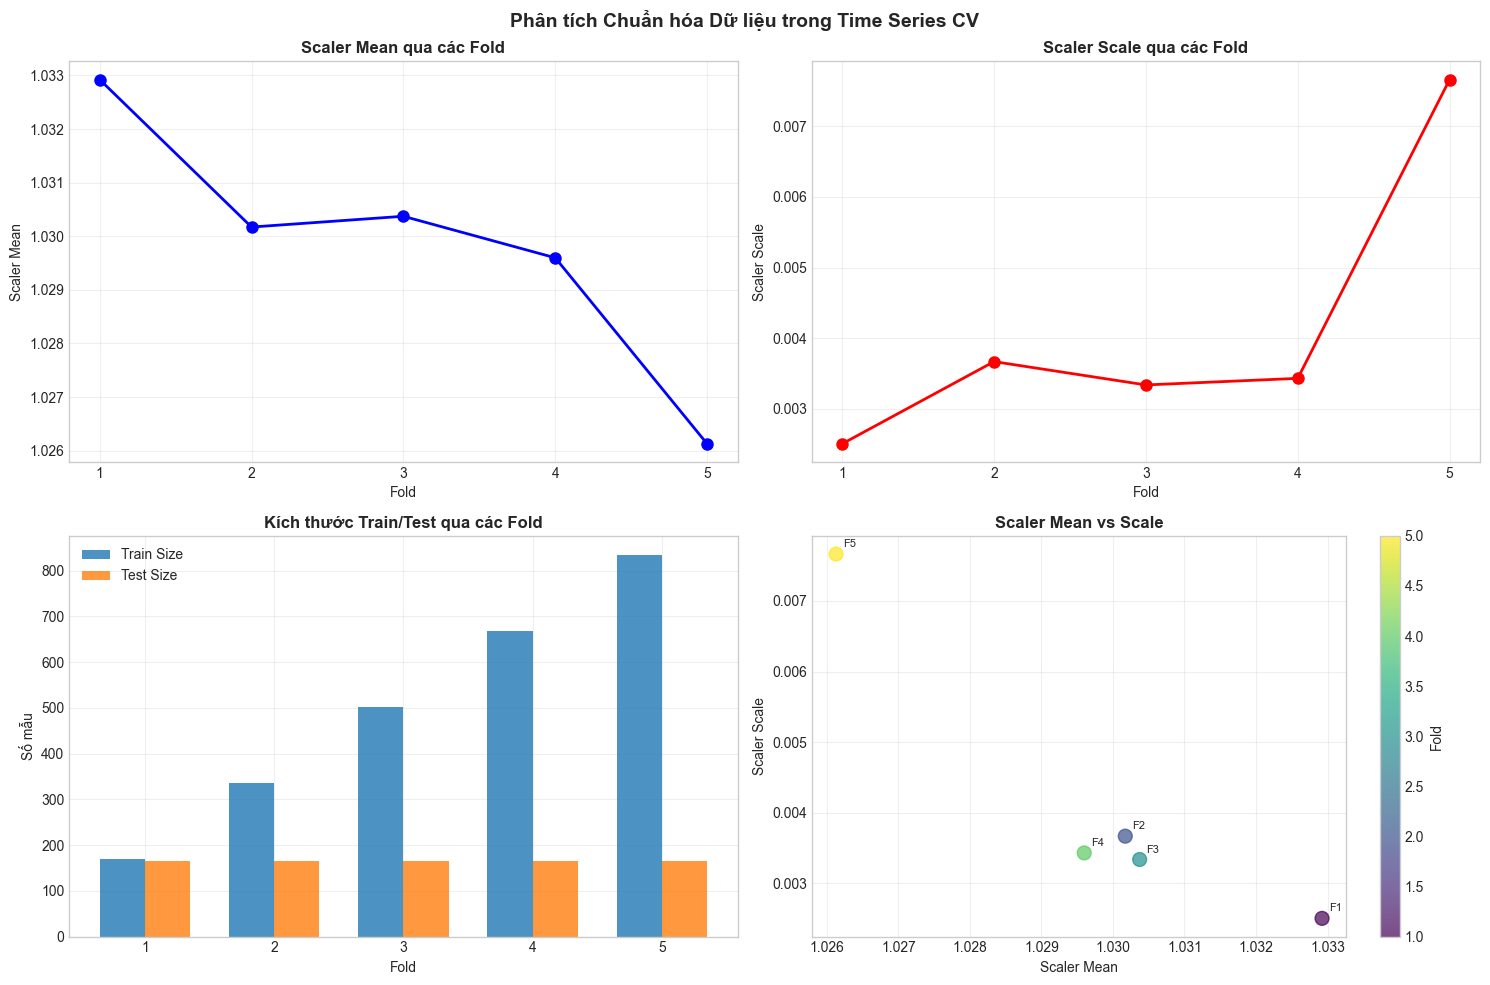

In [34]:
# Vẽ biểu đồ minh họa sự khác biệt
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Phân tích Chuẩn hóa Dữ liệu trong Time Series CV', fontsize=14, fontweight='bold')

# 1. Biểu đồ Scaler Mean qua các fold
axes[0,0].plot(norm_df['fold'], norm_df['scaler_mean'], 'bo-', linewidth=2, markersize=8)
axes[0,0].set_title('Scaler Mean qua các Fold', fontweight='bold')
axes[0,0].set_xlabel('Fold')
axes[0,0].set_ylabel('Scaler Mean')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_xticks(norm_df['fold'])

# 2. Biểu đồ Scaler Scale qua các fold
axes[0,1].plot(norm_df['fold'], norm_df['scaler_scale'], 'ro-', linewidth=2, markersize=8)
axes[0,1].set_title('Scaler Scale qua các Fold', fontweight='bold')
axes[0,1].set_xlabel('Fold')
axes[0,1].set_ylabel('Scaler Scale')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xticks(norm_df['fold'])

# 3. Biểu đồ kích thước train/test
x = norm_df['fold']
width = 0.35
axes[1,0].bar(x - width/2, norm_df['train_size'], width, label='Train Size', alpha=0.8)
axes[1,0].bar(x + width/2, norm_df['test_size'], width, label='Test Size', alpha=0.8)
axes[1,0].set_title('Kích thước Train/Test qua các Fold', fontweight='bold')
axes[1,0].set_xlabel('Fold')
axes[1,0].set_ylabel('Số mẫu')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xticks(norm_df['fold'])

# 4. Scatter plot: Mean vs Scale
scatter = axes[1,1].scatter(norm_df['scaler_mean'], norm_df['scaler_scale'], 
                          c=norm_df['fold'], cmap='viridis', s=100, alpha=0.7)
axes[1,1].set_title('Scaler Mean vs Scale', fontweight='bold')
axes[1,1].set_xlabel('Scaler Mean')
axes[1,1].set_ylabel('Scaler Scale')
axes[1,1].grid(True, alpha=0.3)

# Thêm colorbar
cbar = plt.colorbar(scatter, ax=axes[1,1])
cbar.set_label('Fold')

# Thêm nhãn cho các điểm
for i, row in norm_df.iterrows():
    axes[1,1].annotate(f'F{int(row["fold"])}', 
                      (row['scaler_mean'], row['scaler_scale']),
                      xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()


In [35]:
# So sánh với chuẩn hóa Holdout
print(f"\n🔄 SO SÁNH VỚI CHUẨN HÓA HOLDOUT")
print(f"{'='*50}")

# Thông tin về scaler Holdout
print(f"\n📊 Holdout Validation:")
print(f"   • Train size: {X_train.shape[0]:,} mẫu")
print(f"   • Test size: {X_test.shape[0]:,} mẫu")
print(f"   • Scaler mean (feature 1): {scaler.mean_[0]:.6f}")
print(f"   • Scaler scale (feature 1): {scaler.scale_[0]:.6f}")

# So sánh với Time Series CV
print(f"\n📊 Time Series CV (trung bình):")
print(f"   • Train size trung bình: {norm_df['train_size'].mean():.0f} mẫu")
print(f"   • Test size trung bình: {norm_df['test_size'].mean():.0f} mẫu")
print(f"   • Scaler mean trung bình: {norm_df['scaler_mean'].mean():.6f}")
print(f"   • Scaler scale trung bình: {norm_df['scaler_scale'].mean():.6f}")

# Phân tích sự khác biệt
mean_diff = abs(scaler.mean_[0] - norm_df['scaler_mean'].mean())
scale_diff = abs(scaler.scale_[0] - norm_df['scaler_scale'].mean())

print(f"\n🔍 Sự khác biệt:")
print(f"   • Chênh lệch Mean: {mean_diff:.8f}")
print(f"   • Chênh lệch Scale: {scale_diff:.8f}")
print(f"   • Chênh lệch Mean (%): {(mean_diff/scaler.mean_[0]*100):.4f}%")
print(f"   • Chênh lệch Scale (%): {(scale_diff/scaler.scale_[0]*100):.4f}%")

print(f"\n💡 Kết luận:")
if mean_diff < 0.001 and scale_diff < 0.001:
    print(f"   ✅ Sự khác biệt nhỏ - cả 2 phương pháp đều ổn định")
elif mean_diff < 0.01 and scale_diff < 0.01:
    print(f"   ⚠️  Có sự khác biệt nhẹ - cần chú ý khi so sánh")
else:
    print(f"   🚨 Sự khác biệt đáng kể - Time Series CV cần thiết")

print(f"\n🎯 Khuyến nghị:")
print(f"   • Sử dụng Time Series CV để đánh giá realistic hơn")
print(f"   • Mỗi fold có scaler riêng để tránh data leakage")
print(f"   • Holdout phù hợp cho đánh giá nhanh và deployment")



🔄 SO SÁNH VỚI CHUẨN HÓA HOLDOUT

📊 Holdout Validation:
   • Train size: 470,360 mẫu
   • Test size: 30,053 mẫu
   • Scaler mean (feature 1): 1.213584
   • Scaler scale (feature 1): 0.169494

📊 Time Series CV (trung bình):
   • Train size trung bình: 502 mẫu
   • Test size trung bình: 166 mẫu
   • Scaler mean trung bình: 1.029839
   • Scaler scale trung bình: 0.004119

🔍 Sự khác biệt:
   • Chênh lệch Mean: 0.18374514
   • Chênh lệch Scale: 0.16537477
   • Chênh lệch Mean (%): 15.1407%
   • Chênh lệch Scale (%): 97.5696%

💡 Kết luận:
   🚨 Sự khác biệt đáng kể - Time Series CV cần thiết

🎯 Khuyến nghị:
   • Sử dụng Time Series CV để đánh giá realistic hơn
   • Mỗi fold có scaler riêng để tránh data leakage
   • Holdout phù hợp cho đánh giá nhanh và deployment


# 3. Huấn luyện và đánh giá từng mô hình

## 3.1 Huấn luyện và đánh giá các mô hình của Hold-out

In [ ]:
# Dictionary để lưu trữ kết quả các mô hình
model_results = {}

# Hàm để đánh giá mô hình
def evaluate_model(model, X_test, y_test, model_name):
    st = time.time()
    y_pred = model.predict(X_test)
    et = time.time() - st
    
    results = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'predictions': y_pred,
        'actual': y_test,
        'Train_times': None,
        'Test_times': et
    }
    
    model_results[model_name] = results
    return results

In [45]:
# Dictionary để lưu trữ thời gian tốt nhất các mô hình
time_results = {}

# Hàm để đánh giá mô hình
def time_model(model, X_test, y_test, model_name):
    st = time.time()
    y_pred = model.predict(X_test)
    et = time.time() - st
    results = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'predictions': y_pred,
        'actual': y_test,    
        'Train_times': None,
        'Test_times': et
    }
    
    time_results[model_name] = results
    return results

### 3.1.1 KNN

k=50 --- RMSE: 0.008471521632651321 --- Train Times: 0.08367538452148438s --- Test times: 12.317455053329468s
k=55 --- RMSE: 0.008446086241582882 --- Train Times: 0.09125161170959473s --- Test times: 12.275444030761719s
k=60 --- RMSE: 0.008433332308179456 --- Train Times: 0.08518290519714355s --- Test times: 12.29383134841919s
k=65 --- RMSE: 0.008432323661818272 --- Train Times: 0.09123468399047852s --- Test times: 12.276246547698975s
k=70 --- RMSE: 0.008451219223396242 --- Train Times: 0.08801054954528809s --- Test times: 12.20864725112915s
k=75 --- RMSE: 0.008454427321110356 --- Train Times: 0.08675646781921387s --- Test times: 12.113352060317993s
k=80 --- RMSE: 0.008469746967410744 --- Train Times: 0.08290719985961914s --- Test times: 12.36123251914978s
k=85 --- RMSE: 0.00848312193758869 --- Train Times: 0.08458566665649414s --- Test times: 12.357845783233643s
k=90 --- RMSE: 0.008492711541195611 --- Train Times: 0.09001302719116211s --- Test times: 12.408928632736206s
k=95 --- RMSE:

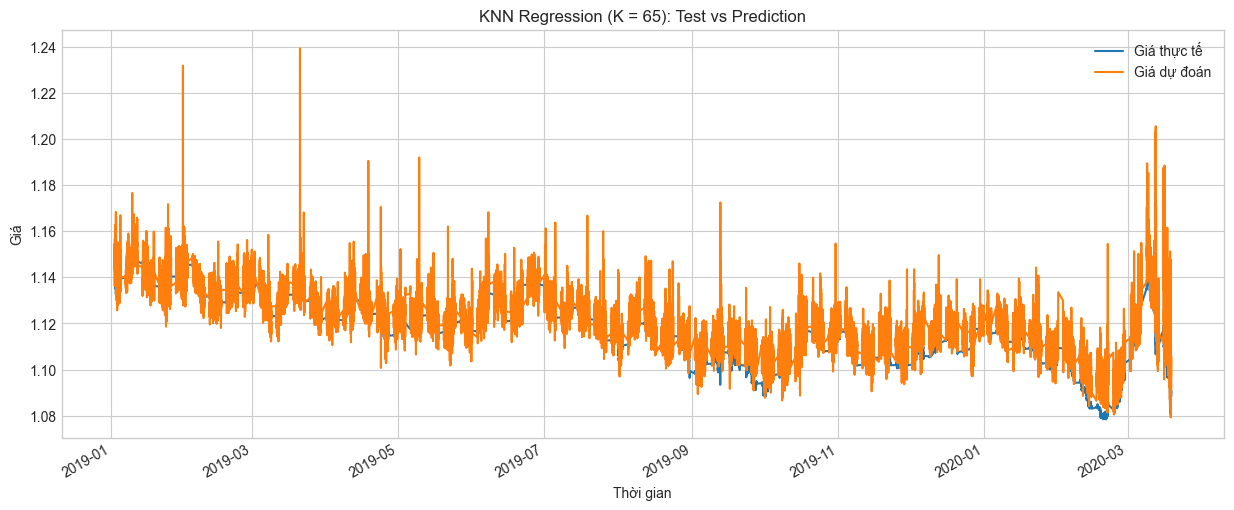

In [ ]:
# ====== Tìm k tốt nhất ======
best_k_value = None
fast_k_value = None
best_rmse = float('inf')
best_time = float('inf')
for k in range(50, 101, 5):
    st = time.time()
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_scaled_train, y_train)
    train = time.time() - st
    st = time.time()
    y_pred = knn.predict(X_scaled_test)
    et = time.time() - st

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"k={k} --- RMSE: {rmse} --- Train Times: {train}s --- Test times: {et}s")

    if best_time > train :
        best_time = train
        fast_k_value = k
        fasttrain = train
        fasttest = et

    if rmse < best_rmse:
        best_rmse = rmse
        best_k_value = k
        besttrain = train
        besttest = et

print(f"\nGiá trị k nhanh nhất: {fast_k_value} với Times: {best_time}")
print(f"\nGiá trị k tốt nhất: {best_k_value} với RMSE: {best_rmse}")

# ====== Huấn luyện mô hình cuối cùng với k nhanh nhất ======
final_knn_model = KNeighborsRegressor(n_neighbors=fast_k_value)
final_knn_model.fit(X_scaled_train, y_train)

# Đánh giá mô hình với hàm time_model
result = time_model(final_knn_model, X_scaled_test, y_test, 'KNN')
time_results['KNN']['Train_times'] = fasttrain 
time_results['KNN']['Test_times'] = fasttest

# In kết quả
print("\nKết quả của mô hình với K nhanh nhất:")
print(f"RMSE: {result['RMSE']}")
print(f"MAE: {result['MAE']}")
print(f"R-squared: {result['R2']}")
print(f"Train times: {result['Train_times']}")
print(f"Test times: {result['Test_times']}")

# ====== Huấn luyện mô hình cuối cùng với k tốt nhất ======
final_knn_model = KNeighborsRegressor(n_neighbors=best_k_value)
final_knn_model.fit(X_scaled_train, y_train)

# Đánh giá mô hình với hàm evaluate_model
result = evaluate_model(final_knn_model, X_scaled_test, y_test, 'KNN')
model_results['KNN']['Train_times'] = besttrain
model_results['KNN']['Test_times'] = besttest

# In kết quả
print("\nKết quả của mô hình với K tốt nhất:")
print(f"RMSE: {result['RMSE']}")
print(f"MAE: {result['MAE']}")
print(f"R-squared: {result['R2']}")
print(f"Train times: {result['Train_times']}")
print(f"Test times: {result['Test_times']}")

# ====== Vẽ biểu đồ ======
test_vs_pred = pd.DataFrame({
    'actual': result['actual'],
    'predictions': result['predictions']
})

test_vs_pred.plot(figsize=(15, 6))
plt.title(f'KNN Regression (K = {best_k_value}): Test vs Prediction')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend(['Giá thực tế', 'Giá dự đoán'])
plt.show()


### 3.1.2 Bayesian Ridge Regression

Lần chạy 1: Alpha = 1e-06
RMSE = 0.0004287528807037463 --- Train times = 1.881580114364624s --- Test time: 0.0018908977508544922s
Lần chạy 2: Alpha = 1e-05
RMSE = 0.00042875288116364906 --- Train times = 1.8315529823303223s --- Test time: 0.0018527507781982422s
Lần chạy 3: Alpha = 0.0001
RMSE = 0.00042875288576361005 --- Train times = 1.7741646766662598s --- Test time: 0.0019838809967041016s
Lần chạy 4: Alpha = 0.001
RMSE = 0.00042875293175075675 --- Train times = 1.810856819152832s --- Test time: 0.0021064281463623047s
Lần chạy 5: Alpha = 0.01
RMSE = 0.00042875339072658225 --- Train times = 1.7787034511566162s --- Test time: 0.0020563602447509766s
Lần chạy 6: Alpha = 0.1
RMSE = 0.00042875790147000464 --- Train times = 1.7627475261688232s --- Test time: 0.004615068435668945s
Lần chạy 7: Alpha = 1.0
RMSE = 0.00042880029556370737 --- Train times = 1.7725396156311035s --- Test time: 0.0018563270568847656s
Lần chạy 8: Alpha = 10.0
RMSE = 0.00042943230715287826 --- Train times = 1.793497562

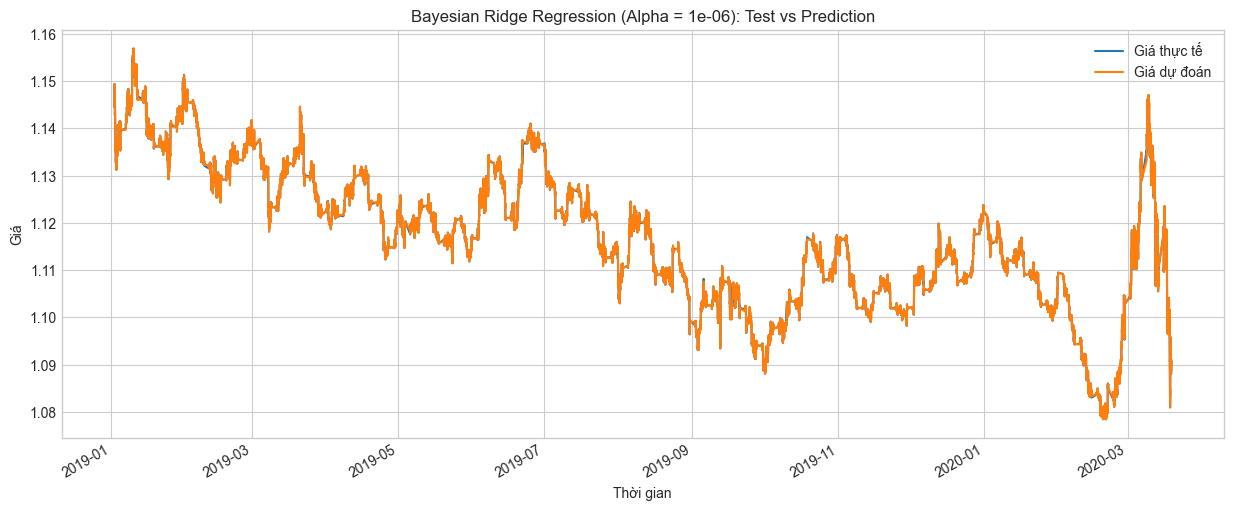

In [ ]:
# ===== Khởi tạo và tìm alpha tốt nhất =====
rmse_scores = []
alpha_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0, 1000.0]
best_alpha = None
fast_alpha = None
best_rmse = float('inf')
best_time = float('inf')

for i, alpha in enumerate(alpha_values):
    st = time.time()
    bayes_ridge = BayesianRidge(alpha_1=alpha, alpha_2=alpha)
    bayes_ridge.fit(X_scaled_train, y_train)
    train = time.time() - st
    st = time.time()
    y_pred = bayes_ridge.predict(X_scaled_test)
    et = time.time() - st
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    print(f"Lần chạy {i+1}: Alpha = {alpha}\nRMSE = {rmse} --- Train times = {train}s --- Test time: {et}s")

    if best_time > et :
        best_time = et
        fast_alpha = alpha
        fasttrain = train
        fasttest = et

    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha
        besttrain = train
        besttest = et

print(f"\nGiá trị alpha nhanh nhất: {fast_alpha} với Times: {best_time}")
print(f"\nGiá trị alpha tốt nhất: {best_alpha} với RMSE: {best_rmse}")
# Tính trung bình và độ lệch chuẩn RMSE
avg_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

# Bảng so sánh alpha
print("\n" + "="*60)
print("BẢNG SO SÁNH CÁC GIÁ TRỊ ALPHA")
print("="*60)
print(f"{'Alpha':<15} {'RMSE':<20} {'Xếp hạng':<10}")
print("-"*60)

results_table = list(zip(alpha_values, rmse_scores))
results_sorted = sorted(results_table, key=lambda x: x[1])

for rank, (alpha, rmse) in enumerate(results_sorted, 1):
    status = "⭐ TỐT NHẤT" if alpha == best_alpha else ""
    print(f"{alpha:<15} {rmse:<20.8f} {rank:<10} {status}")

print("="*60)
print(f"RMSE trung bình qua các alpha: {avg_rmse:.8f}")
print(f"Độ lệch chuẩn RMSE: {std_rmse:.8f}")
print(f"RMSE tốt nhất: {best_rmse:.8f}")
print(f"RMSE tệ nhất: {max(rmse_scores):.8f}")

# ===== Huấn luyện lại mô hình với alpha nhanh nhất =====
print(f"\nHuấn luyện mô hình Bayesian Ridge với alpha nhanh nhất: {fast_alpha}")
final_bayes_ridge = BayesianRidge(alpha_1=fast_alpha, alpha_2=fast_alpha)
final_bayes_ridge.fit(X_scaled_train, y_train)

# Đánh giá mô hình nhanh nhất và lưu kết quả
result = time_model(final_bayes_ridge, X_scaled_test, y_test, 'Bayesian Ridge')
time_results['Bayesian Ridge']['Train_times'] = fasttrain
time_results['Bayesian Ridge']['Test_times'] = fasttest

# In ra kết quả
print(f"\nHiệu suất mô hình Bayesian Ridge nhanh nhất (Alpha = {fast_alpha}):")
print(f"RMSE: {result['RMSE']}")
print(f"MAE: {result['MAE']}")
print(f"R-squared: {result['R2']}")
print(f"Train times: {result['Train_times']}")
print(f"Test times: {result['Test_times']}")

# ===== Huấn luyện lại mô hình với alpha tốt nhất =====
print(f"\nHuấn luyện mô hình Bayesian Ridge với alpha tốt nhất: {best_alpha}")
final_bayes_ridge = BayesianRidge(alpha_1=best_alpha, alpha_2=best_alpha)
final_bayes_ridge.fit(X_scaled_train, y_train)

# Đánh giá mô hình tốt nhất và lưu kết quả
result = evaluate_model(final_bayes_ridge, X_scaled_test, y_test, 'Bayesian Ridge')
model_results['Bayesian Ridge']['Train_times'] = besttrain
model_results['Bayesian Ridge']['Test_times'] = besttest

# In ra kết quả
print(f"\nHiệu suất mô hình Bayesian Ridge tốt nhất (Alpha = {best_alpha}):")
print(f"RMSE: {result['RMSE']}")
print(f"MAE: {result['MAE']}")
print(f"R-squared: {result['R2']}")
print(f"Train times: {result['Train_times']}")
print(f"Test times: {result['Test_times']}")

# Vẽ biểu đồ kết quả
test_vs_pred = pd.DataFrame({
    'actual': result['actual'],
    'predictions': result['predictions']
})

test_vs_pred.plot(figsize=(15, 6))
plt.title(f'Bayesian Ridge Regression (Alpha = {best_alpha}): Test vs Prediction')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend(['Giá thực tế', 'Giá dự đoán'])
plt.show()


### 3.1.3 DecisionTree


Chạy Decision Tree Regressor với các max_depth khác nhau...
Lần chạy 1/10: Max_depth = 3
RMSE: 0.02237209596358077 --- Train times: 8.610931634902954s --- Test times: 0.0029649734497070312s
Lần chạy 2/10: Max_depth = 5
RMSE: 0.00490072510465022 --- Train times: 13.268708944320679s --- Test times: 0.0033152103424072266s
Lần chạy 3/10: Max_depth = 7
RMSE: 0.0013429175718714461 --- Train times: 17.50788140296936s --- Test times: 0.0026946067810058594s

Giá trị Max_depth nhanh nhất: 7 với Times: 0.0026946067810058594

Giá trị Max_depth tốt nhất: 7 với RMSE: 0.0013429175718714461

BẢNG SO SÁNH CÁC GIÁ TRỊ MAX_DEPTH
Max_Depth       RMSE                 Xếp hạng   Ghi chú        
----------------------------------------------------------------------
7               0.00134292           1          ⭐ TỐT NHẤT Tối ưu
5               0.00490073           2           
3               0.02237210           3           
RMSE trung bình qua các max_depth: 0.00953858
Độ lệch chuẩn RMSE: 0.00919017
RMS

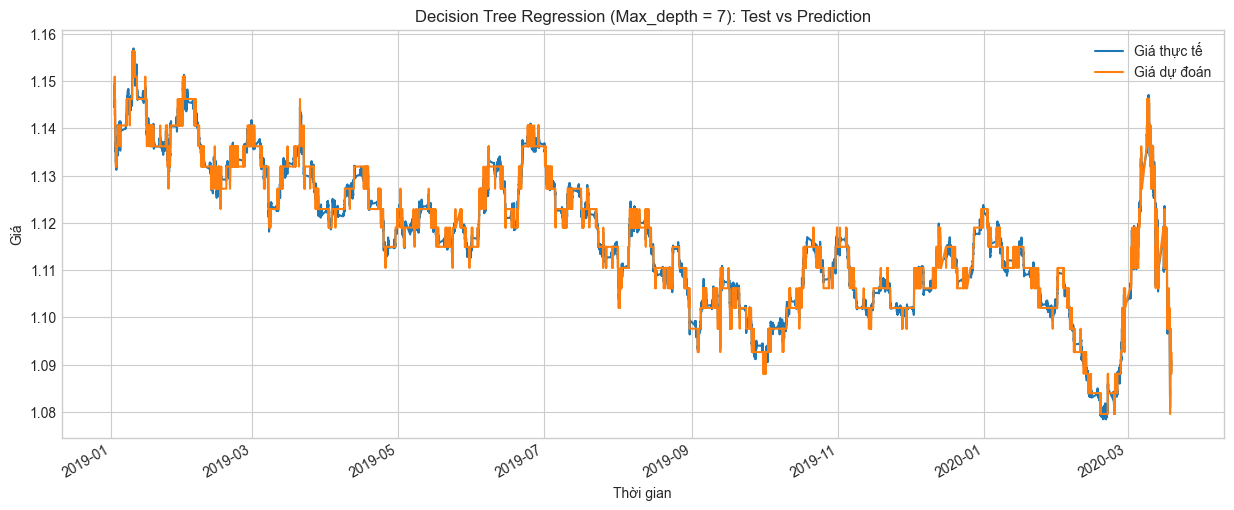

In [ ]:
# ===== Tìm max_depth tốt nhất =====
rmse_scores_dt = []
max_depth_values = [None, 3, 5, 7, 10, 15, 20, 25, 30, 50]
best_depth = None
fast_depth = None
best_rmse_dt = float('inf')
best_time = float('inf')

print("\nChạy Decision Tree Regressor với các max_depth khác nhau...")
for i, max_depth in enumerate(max_depth_values):
    st = time.time()
    dt_run = DecisionTreeRegressor(random_state=42, max_depth=max_depth)
    dt_run.fit(X_scaled_train, y_train)
    train = time.time() - st

    st = time.time()
    y_pred_dt = dt_run.predict(X_scaled_test)
    et = time.time() - st

    rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
    rmse_scores_dt.append(rmse_dt)

    print(f"Lần chạy {i+1}/10: Max_depth = {max_depth}\nRMSE: {rmse_dt} --- Train times: {train}s --- Test times: {et}s")

    if best_time > et :
        best_time = et
        fast_depth = max_depth
        fasttrain = train
        fasttest = et

    if rmse_dt < best_rmse_dt:
        best_rmse_dt = rmse_dt
        best_depth = max_depth
        besttrain = train
        besttest = et

print(f"\nGiá trị Max_depth nhanh nhất: {fast_depth} với Times: {best_time}")
print(f"\nGiá trị Max_depth tốt nhất: {best_depth} với RMSE: {best_rmse_dt}")

# ===== Thống kê bảng so sánh max_depth =====
print("\n" + "="*70)
print("BẢNG SO SÁNH CÁC GIÁ TRỊ MAX_DEPTH")
print("="*70)
print(f"{'Max_Depth':<15} {'RMSE':<20} {'Xếp hạng':<10} {'Ghi chú':<15}")
print("-"*70)

results_dt = list(zip(max_depth_values, rmse_scores_dt))
results_dt_sorted = sorted(results_dt, key=lambda x: x[1])

for rank, (depth, rmse) in enumerate(results_dt_sorted, 1):
    depth_str = str(depth) if depth is not None else 'Không giới hạn'
    status = "⭐ TỐT NHẤT" if depth == best_depth else ""
    note = "Có thể overfitting" if depth is None or (depth is not None and depth > 30) else "Tối ưu" if depth == best_depth else ""
    print(f"{depth_str:<15} {rmse:<20.8f} {rank:<10} {status} {note}")

print("="*70)
print(f"RMSE trung bình qua các max_depth: {np.mean(rmse_scores_dt):.8f}")
print(f"Độ lệch chuẩn RMSE: {np.std(rmse_scores_dt):.8f}")
print(f"RMSE tốt nhất: {min(rmse_scores_dt):.8f}")
print(f"RMSE tệ nhất: {max(rmse_scores_dt):.8f}")

# ===== Huấn luyện lại mô hình với max_depth nhanh nhất =====
print(f"\nHuấn luyện mô hình Decision Tree với max_depth nhanh nhất: {fast_depth}")
final_dt_model = DecisionTreeRegressor(random_state=42, max_depth=fast_depth)
final_dt_model.fit(X_scaled_train, y_train)

# Đánh giá mô hình bằng evaluate_model
depth_str = str(best_depth) if best_depth is not None else 'Không giới hạn'
result = time_model(final_dt_model, X_scaled_test, y_test, 'Decision Tree')
time_results['Decision Tree']['Train_times'] = fasttrain
time_results['Decision Tree']['Test_times'] = fasttest

# In kết quả mô hình nhanh nhất
print(f"\nHiệu suất mô hình Decision Tree nhanh nhất (Max_depth = {depth_str}):")
print(f"RMSE: {result['RMSE']}")
print(f"MAE: {result['MAE']}")
print(f"R-squared: {result['R2']}")
print(f"Train times: {result['Train_times']}")
print(f"Test times: {result['Test_times']}")

# ===== Huấn luyện lại mô hình với max_depth tốt nhất =====
print(f"\nHuấn luyện mô hình Decision Tree với max_depth tốt nhất: {best_depth}")
final_dt_model = DecisionTreeRegressor(random_state=42, max_depth=best_depth)
final_dt_model.fit(X_scaled_train, y_train)

# Đánh giá mô hình bằng evaluate_model
depth_str = str(best_depth) if best_depth is not None else 'Không giới hạn'
result = evaluate_model(final_dt_model, X_scaled_test, y_test, 'Decision Tree')
model_results['Decision Tree']['Train_times'] = besttrain
model_results['Decision Tree']['Test_times'] = besttest

# In kết quả mô hình tốt nhất
print(f"\nHiệu suất mô hình Decision Tree tốt nhất (Max_depth = {depth_str}):")
print(f"RMSE: {result['RMSE']}")
print(f"MAE: {result['MAE']}")
print(f"R-squared: {result['R2']}")
print(f"Train times: {result['Train_times']}")
print(f"Test times: {result['Test_times']}")

# ===== Vẽ biểu đồ kết quả =====
test_vs_pred_dt = pd.DataFrame({
    'actual': result['actual'],
    'predictions': result['predictions']
})

test_vs_pred_dt.plot(figsize=(15, 6))
plt.title(f'Decision Tree Regression (Max_depth = {depth_str}): Test vs Prediction')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend(['Giá thực tế', 'Giá dự đoán'])
plt.show()


### 3.1.4 Linear Regression

In [ ]:
# ===== Huấn luyện mô hình Linear Regression =====
st = time.time()
lin_reg = LinearRegression()
lin_reg.fit(X_scaled_train, y_train)
et = time.time() - st

# Đánh giá và lưu kết quả với tên mô hình "Linear Regression"
result = evaluate_model(lin_reg, X_scaled_test, y_test, 'Linear Regression')
model_results['Linear Regression']['Train_times'] = et
# In kết quả
print("\nKết quả mô hình Linear Regression:")
print(f"Root Mean Squared Error: {result['RMSE']}")
print(f"Mean Absolute Error: {result['MAE']}")
print(f"R-squared: {result['R2']}")
print(f"Train times: {result['Train_times']}")
print(f"Test times: {result['Test_times']}")

# Vẽ biểu đồ kết quả
test_vs_pred = pd.DataFrame({
    'actual': result['actual'],
    'predictions': result['predictions']
})

test_vs_pred.plot(figsize=(15, 6))
plt.title('Linear Regression: Test vs Prediction')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend(['Giá thực tế', 'Giá dự đoán'])
plt.show()


### 3.1.5 Support Vector Regressor

In [ ]:
# ===== Huấn luyện mô hình SVR =====
st = time.time()
svr = SVR()
svr.fit(X_scaled_train, y_train)
et = time.time() - st

# Đánh giá mô hình và lưu kết quả
result = evaluate_model(svr, X_scaled_test, y_test, 'Support Vector Regressor')
model_results['Support Vector Regressor']['Train_times'] = et

# In kết quả
print("\nKết quả mô hình Support Vector Regressor:")
print(f"Root Mean Squared Error: {result['RMSE']}")
print(f"Mean Absolute Error: {result['MAE']}")
print(f"R-squared: {result['R2']}")
print(f"Train times: {result['Train_times']}")
print(f"Test times: {result['Test_times']}")

# Vẽ biểu đồ kết quả
test_vs_pred = pd.DataFrame({
    'actual': result['actual'],
    'predictions': result['predictions']
})

test_vs_pred.plot(figsize=(15, 6))
plt.title('Support Vector Regressor: Test vs Prediction')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend(['Giá thực tế', 'Giá dự đoán'])
plt.show()


### 3.1.6 Bagging Regressor

In [ ]:
# ===== Huấn luyện mô hình Bagging Regressor =====
st = time.time()
bag_reg = BaggingRegressor(n_estimators=200, n_jobs=-1, random_state=42)
bag_reg.fit(X_scaled_train, y_train)
et = time.time() - st

# Đánh giá mô hình và lưu kết quả
result = evaluate_model(bag_reg, X_scaled_test, y_test, 'Bagging Regressor')
model_results['Bagging Regressor']['Train_times'] = et

# In kết quả
print("\nKết quả mô hình Bagging Regressor:")
print(f"Root Mean Squared Error: {result['RMSE']}")
print(f"Mean Absolute Error: {result['MAE']}")
print(f"R-squared: {result['R2']}")
print(f"Train times: {result['Train_times']}")
print(f"Test times: {result['Test_times']}")

# Vẽ biểu đồ kết quả
test_vs_pred = pd.DataFrame({
    'actual': result['actual'],
    'predictions': result['predictions']
})

test_vs_pred.plot(figsize=(15, 6))
plt.title('Bagging Regressor: Test vs Prediction')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend(['Giá thực tế', 'Giá dự đoán'])
plt.show()


### 3.1.7 Random Forest Regressor

In [ ]:
# ===== Huấn luyện mô hình Random Forest Regressor =====
st = time.time()
rf_reg = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
rf_reg.fit(X_scaled_train, y_train)
et = time.time() - st

# Đánh giá mô hình và lưu kết quả
result = evaluate_model(rf_reg, X_scaled_test, y_test, 'Random Forest Regressor')
model_results['Random Forest Regressor']['Train_times'] = et

# In kết quả
print("\nKết quả mô hình Random Forest Regressor:")
print(f"Root Mean Squared Error: {result['RMSE']}")
print(f"Mean Absolute Error: {result['MAE']}")
print(f"R-squared: {result['R2']}")
print(f"Train times: {result['Train_times']}")
print(f"Test times: {result['Test_times']}")

# Vẽ biểu đồ kết quả
test_vs_pred = pd.DataFrame({
    'actual': result['actual'],
    'predictions': result['predictions']
})

test_vs_pred.plot(figsize=(15, 6))
plt.title('Random Forest Regressor: Test vs Prediction')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend(['Giá thực tế', 'Giá dự đoán'])
plt.show()


### 3.1.8 XGBoost Regressor

In [ ]:
# ===== Huấn luyện mô hình XGBoost Regressor =====
st = time.time()
xgb_reg = XGBRegressor(n_estimators=500, n_jobs=-1, random_state=42)
xgb_reg.fit(X_scaled_train, y_train)
et = time.time() - st

# Đánh giá mô hình và lưu kết quả
result = evaluate_model(xgb_reg, X_scaled_test, y_test, 'XGBoost Regressor')
model_results['XGBoost Regressor']['Train_times'] = et

# In kết quả
print("\nKết quả mô hình XGBoost Regressor:")
print(f"Root Mean Squared Error: {result['RMSE']}")
print(f"Mean Absolute Error: {result['MAE']}")
print(f"R-squared: {result['R2']}")
print(f"Train times: {result['Train_times']}")
print(f"Test times: {result['Test_times']}")

# Vẽ biểu đồ kết quả
test_vs_pred = pd.DataFrame({
    'actual': result['actual'],
    'predictions': result['predictions']
})

test_vs_pred.plot(figsize=(15, 6))
plt.title('XGBoost Regressor: Test vs Prediction')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend(['Giá thực tế', 'Giá dự đoán'])
plt.show()


In [ ]:
for model_name, result in model_results.items():
    print(f"{model_name:<30} RMSE = {result['RMSE']:.4f}")

## 3.2 Huấn luyện và đánh giá các mô hình của Time Series Cross-Validation

Phần này sẽ huấn luyện tất cả các mô hình bằng Time Series Cross-Validation.

In [ ]:
# Dictionary để lưu kết quả Time Series CV
time_series_cv_results = {}

Hàm train các mô hình Time Series CV

In [ ]:
# Import thêm thư viện cần thiết cho Time Series CV
from sklearn.base import clone
# Hàm để huấn luyện và đánh giá mô hình với Time Series CV
def train_with_time_series_cv(model, model_name, X, y, n_splits=5):
    """
    Huấn luyện mô hình với Time Series Cross-Validation
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    cv_scores = {
        'RMSE': [],
        'MAE': [],
        'R2': []
    }
    
    fold_results = []
    
    print(f"\n{'='*60}")
    print(f"HUẤN LUYỆN {model_name.upper()} VỚI TIME SERIES CV")
    print(f"{'='*60}")
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        # Chia dữ liệu cho fold hiện tại
        X_train_fold = X.iloc[train_idx]
        X_test_fold = X.iloc[test_idx]
        y_train_fold = y.iloc[train_idx]
        y_test_fold = y.iloc[test_idx]
        
        # Chuẩn hóa dữ liệu cho fold
        scaler_fold = StandardScaler()
        X_train_scaled = scaler_fold.fit_transform(X_train_fold)
        X_test_scaled = scaler_fold.transform(X_test_fold)
        
        # Huấn luyện mô hình
        model_fold = clone(model)
        model_fold.fit(X_train_scaled, y_train_fold)
        
        # Dự đoán
        y_pred_fold = model_fold.predict(X_test_scaled)
        
        # Tính toán metrics
        rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
        mae = mean_absolute_error(y_test_fold, y_pred_fold)
        r2 = r2_score(y_test_fold, y_pred_fold)
        
        cv_scores['RMSE'].append(rmse)
        cv_scores['MAE'].append(mae)
        cv_scores['R2'].append(r2)
        
        fold_results.append({
            'fold': fold + 1,
            'train_size': len(train_idx),
            'test_size': len(test_idx),
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })
        
        print(f"Fold {fold+1}: RMSE={rmse:.6f}, MAE={mae:.6f}, R²={r2:.6f}")
    
    # Tính toán thống kê tổng hợp
    cv_summary = {
        'model_name': model_name,
        'RMSE_mean': np.mean(cv_scores['RMSE']),
        'RMSE_std': np.std(cv_scores['RMSE']),
        'MAE_mean': np.mean(cv_scores['MAE']),
        'MAE_std': np.std(cv_scores['MAE']),
        'R2_mean': np.mean(cv_scores['R2']),
        'R2_std': np.std(cv_scores['R2']),
        'fold_results': fold_results
    }
    
    print(f"\nKết quả trung bình:")
    print(f"RMSE: {cv_summary['RMSE_mean']:.6f} ± {cv_summary['RMSE_std']:.6f}")
    print(f"MAE: {cv_summary['MAE_mean']:.6f} ± {cv_summary['MAE_std']:.6f}")
    print(f"R²: {cv_summary['R2_mean']:.6f} ± {cv_summary['R2_std']:.6f}")
    
    return cv_summary

### 3.2.1 KNN

In [ ]:
# KNN với Time Series CV - thử nghiệm các giá trị k
print("\n🔍 ĐANG TÌM K TỐT NHẤT CHO KNN VỚI TIME SERIES CV...")

k_values = range(1, 16)
k_cv_results = []

for k in k_values:
    knn_model = KNeighborsRegressor(n_neighbors=k)
    cv_result = train_with_time_series_cv(knn_model, f'KNN (k={k})', X_full, y_full)
    k_cv_results.append((k, cv_result['RMSE_mean']))

# Tìm k tốt nhất
best_k_cv = min(k_cv_results, key=lambda x: x[1])
print(f"\n🏆 K TỐT NHẤT VỚI TIME SERIES CV: {best_k_cv[0]} (RMSE: {best_k_cv[1]:.6f})")

# Huấn luyện lại với k tốt nhất
knn_best_cv = KNeighborsRegressor(n_neighbors=best_k_cv[0])
knn_cv_final = train_with_time_series_cv(knn_best_cv, 'KNN', X_full, y_full)

time_series_cv_results['KNN'] = knn_cv_final


### 3.2.2 Bayesian Ridge Regression

In [ ]:
# Bayesian Ridge với Time Series CV - thử nghiệm các giá trị alpha
print("\n🔍 ĐANG TÌM ALPHA TỐT NHẤT CHO BAYESIAN RIDGE VỚI TIME SERIES CV...")

alpha_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0, 1000.0]
alpha_cv_results = []

for alpha in alpha_values:
    bayes_model = BayesianRidge(alpha_1=alpha, alpha_2=alpha)
    cv_result = train_with_time_series_cv(bayes_model, f'Bayesian Ridge (α={alpha})', X_full, y_full)
    alpha_cv_results.append((alpha, cv_result['RMSE_mean']))

# Tìm alpha tốt nhất
best_alpha_cv = min(alpha_cv_results, key=lambda x: x[1])
print(f"\n🏆 ALPHA TỐT NHẤT VỚI TIME SERIES CV: {best_alpha_cv[0]} (RMSE: {best_alpha_cv[1]:.6f})")

# Huấn luyện lại với alpha tốt nhất
bayes_best_cv = BayesianRidge(alpha_1=best_alpha_cv[0], alpha_2=best_alpha_cv[0])
bayes_cv_final = train_with_time_series_cv(bayes_best_cv, 'Bayesian Ridge', X_full, y_full)

time_series_cv_results['Bayesian Ridge'] = bayes_cv_final

### 3.2.3 Decision Tree

In [ ]:
# Decision Tree với Time Series CV - thử nghiệm các giá trị max_depth
print("\n🔍 ĐANG TÌM MAX_DEPTH TỐT NHẤT CHO DECISION TREE VỚI TIME SERIES CV...")

max_depth_values = [3, 5, 7, 10, 15, 20, 25, 30, None, 50]
depth_cv_results = []

for depth in max_depth_values:
    dt_model = DecisionTreeRegressor(random_state=42, max_depth=depth)
    depth_str = str(depth) if depth is not None else 'None'
    cv_result = train_with_time_series_cv(dt_model, f'Decision Tree (depth={depth_str})', X_full, y_full)
    depth_cv_results.append((depth, cv_result['RMSE_mean']))

# Tìm max_depth tốt nhất
best_depth_cv = min(depth_cv_results, key=lambda x: x[1])
depth_str = str(best_depth_cv[0]) if best_depth_cv[0] is not None else 'None'
print(f"\n🏆 MAX_DEPTH TỐT NHẤT VỚI TIME SERIES CV: {depth_str} (RMSE: {best_depth_cv[1]:.6f})")

# Huấn luyện lại với max_depth tốt nhất
dt_best_cv = DecisionTreeRegressor(random_state=42, max_depth=best_depth_cv[0])
dt_cv_final = train_with_time_series_cv(dt_best_cv, 'Decision Tree', X_full, y_full)

time_series_cv_results['Decision Tree'] = dt_cv_final

### 3.2.4 Linear Regression

In [ ]:
# Linear Regression
lr_model = LinearRegression()
lr_cv_result = train_with_time_series_cv(lr_model, 'Linear Regression', X_full, y_full)
time_series_cv_results['Linear Regression'] = lr_cv_result


### 3.2.5 Support Vector Regressor

In [ ]:
# Support Vector Regressor
svr_model = SVR()
svr_cv_result = train_with_time_series_cv(svr_model, 'Support Vector Regressor', X_full, y_full)
time_series_cv_results['SVR'] = svr_cv_result


### 3.2.6 Bagging Regressor

In [ ]:
# Bagging Regressor
bagging_model = BaggingRegressor(n_estimators=100, n_jobs=-1, random_state=42)
bagging_cv_result = train_with_time_series_cv(bagging_model, 'Bagging Regressor', X_full, y_full)
time_series_cv_results['Bagging Regressor'] = bagging_cv_result

### 3.2.7 Random Forest Regressor

In [ ]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf_cv_result = train_with_time_series_cv(rf_model, 'Random Forest Regressor', X_full, y_full)
time_series_cv_results['Random Forest Regressor'] = rf_cv_result

### 3.2.8 XGBoost Regressor

In [ ]:
# XGBoost
xgb_model = XGBRegressor(n_estimators=100, n_jobs=-1, random_state=42)
xgb_cv_result = train_with_time_series_cv(xgb_model, 'XGBoost Regressor', X_full, y_full)
time_series_cv_results['XGBoost Regressor'] = xgb_cv_result

# 4. Đánh giá và so sánh mô hình

Phần này sẽ thực hiện đánh giá toàn diện các mô hình đã huấn luyện thông qua nhiều tiêu chí khác nhau.

## 4.1 Thu thập kết quả từ tất cả mô hình

In [ ]:
print(f"Đã thu thập kết quả từ {len(model_results)} mô hình!")

## 4.2 So sánh phương pháp validation

Trước khi so sánh các mô hình, chúng ta sẽ so sánh hiệu quả của 2 phương pháp validation: Holdout và Time Series Cross-Validation.

### 4.2.1 Kết quả Time Series Cross-Validation


In [ ]:
# Chuẩn bị dữ liệu đầy đủ cho Time Series CV
X_full = data.drop('close', axis='columns')
y_full = data['close']

print(f"Dữ liệu đầy đủ: {X_full.shape[0]} mẫu, {X_full.shape[1]} features")


In [ ]:
# Tạo bảng so sánh kết quả Time Series CV
cv_comparison_data = []
for model_name, results in time_series_cv_results.items():
    cv_comparison_data.append({
        'Mô hình': model_name,
        'RMSE_mean': results['RMSE_mean'],
        'RMSE_std': results['RMSE_std'],
        'MAE_mean': results['MAE_mean'],
        'MAE_std': results['MAE_std'],
        'R2_mean': results['R2_mean'],
        'R2_std': results['R2_std']
    })

cv_comparison_df = pd.DataFrame(cv_comparison_data)
cv_comparison_df = cv_comparison_df.sort_values('RMSE_mean')
cv_comparison_df['Xếp hạng'] = range(1, len(cv_comparison_df) + 1)

# Hiển thị bảng
print("\n" + "="*100)
print("BẢNG SO SÁNH KẾT QUẢ TIME SERIES CROSS-VALIDATION")
print("="*100)
print(f"{'Rank':<5} {'Mô hình':<25} {'RMSE (mean±std)':<20} {'MAE (mean±std)':<20} {'R² (mean±std)':<15}")
print("-"*100)

for _, row in cv_comparison_df.iterrows():
    rank_symbol = "🥇" if row['Xếp hạng'] == 1 else "🥈" if row['Xếp hạng'] == 2 else "🥉" if row['Xếp hạng'] == 3 else "  "
    rmse_str = f"{row['RMSE_mean']:.6f}±{row['RMSE_std']:.6f}"
    mae_str = f"{row['MAE_mean']:.6f}±{row['MAE_std']:.6f}"
    r2_str = f"{row['R2_mean']:.4f}±{row['R2_std']:.4f}"
    
    print(f"{rank_symbol}{row['Xếp hạng']:<4} {row['Mô hình']:<25} {rmse_str:<20} {mae_str:<20} {r2_str:<15}")

print("="*100)

# Mô hình tốt nhất với Time Series CV
best_cv_model = cv_comparison_df.iloc[0]
print(f"\n🏆 MÔ HÌNH TỐT NHẤT VỚI TIME SERIES CV: {best_cv_model['Mô hình']}")
print(f"   RMSE: {best_cv_model['RMSE_mean']:.6f} ± {best_cv_model['RMSE_std']:.6f}")
print(f"   MAE: {best_cv_model['MAE_mean']:.6f} ± {best_cv_model['MAE_std']:.6f}")
print(f"   R²: {best_cv_model['R2_mean']:.4f} ± {best_cv_model['R2_std']:.4f}")


### 4.2.2 Biểu đồ so sánh Time Series CV


In [ ]:
# Vẽ biểu đồ so sánh kết quả Time Series CV
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Kết quả Time Series Cross-Validation', fontsize=16, fontweight='bold')

# Chuẩn bị dữ liệu
models = cv_comparison_df['Mô hình'].tolist()
rmse_means = cv_comparison_df['RMSE_mean'].tolist()
rmse_stds = cv_comparison_df['RMSE_std'].tolist()
mae_means = cv_comparison_df['MAE_mean'].tolist()
mae_stds = cv_comparison_df['MAE_std'].tolist()
r2_means = cv_comparison_df['R2_mean'].tolist()
r2_stds = cv_comparison_df['R2_std'].tolist()

model_names_short = [name.split('(')[0].strip() for name in models]
colors = plt.cm.Set3(np.linspace(0, 1, len(models)))

# 1. RMSE với error bars
bars1 = axes[0,0].bar(range(len(models)), rmse_means, yerr=rmse_stds, 
                     color=colors, capsize=5, alpha=0.8)
axes[0,0].set_title('RMSE (Time Series CV)', fontweight='bold')
axes[0,0].set_xlabel('Mô hình')
axes[0,0].set_ylabel('RMSE')
axes[0,0].set_xticks(range(len(models)))
axes[0,0].set_xticklabels(model_names_short, rotation=45, ha='right')
axes[0,0].grid(True, alpha=0.3)

# 2. MAE với error bars
bars2 = axes[0,1].bar(range(len(models)), mae_means, yerr=mae_stds, 
                     color=colors, capsize=5, alpha=0.8)
axes[0,1].set_title('MAE (Time Series CV)', fontweight='bold')
axes[0,1].set_xlabel('Mô hình')
axes[0,1].set_ylabel('MAE')
axes[0,1].set_xticks(range(len(models)))
axes[0,1].set_xticklabels(model_names_short, rotation=45, ha='right')
axes[0,1].grid(True, alpha=0.3)

# 3. R² với error bars
bars3 = axes[1,0].bar(range(len(models)), r2_means, yerr=r2_stds, 
                     color=colors, capsize=5, alpha=0.8)
axes[1,0].set_title('R² (Time Series CV)', fontweight='bold')
axes[1,0].set_xlabel('Mô hình')
axes[1,0].set_ylabel('R²')
axes[1,0].set_xticks(range(len(models)))
axes[1,0].set_xticklabels(model_names_short, rotation=45, ha='right')
axes[1,0].grid(True, alpha=0.3)

# 4. Stability plot (RMSE std vs mean)
scatter = axes[1,1].scatter(rmse_means, rmse_stds, c=range(len(models)), 
                          cmap='viridis', s=100, alpha=0.7)
axes[1,1].set_title('Độ ổn định mô hình (RMSE)', fontweight='bold')
axes[1,1].set_xlabel('RMSE Mean')
axes[1,1].set_ylabel('RMSE Std (Độ biến động)')
axes[1,1].grid(True, alpha=0.3)

# Thêm nhãn cho scatter plot
for i, model in enumerate(model_names_short):
    axes[1,1].annotate(model, (rmse_means[i], rmse_stds[i]),
                      xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

print("\n📊 Giải thích biểu đồ:")
print("- Error bars thể hiện độ biến động qua các folds")
print("- Mô hình tốt: RMSE/MAE thấp, R² cao, độ biến động nhỏ")
print("- Scatter plot: Góc trái dưới = mô hình tốt và ổn định")


### 4.2.3 So sánh Holdout vs Time Series Cross-Validation

Phần này sẽ so sánh kết quả giữa phương pháp Holdout Validation (train: 2000-2018, test: 2019-2020) và Time Series Cross-Validation.

In [ ]:
# Tạo bảng so sánh chi tiết
comparison_detailed = []

for model_name in model_results.keys():
    holdout = model_results[model_name]
    
    # Tìm kết quả Time Series CV tương ứng
    timeseries = None
    for ts_name, ts_result in time_series_cv_results.items():
        if model_name in ts_name or ts_name in model_name:
            timeseries = ts_result
            break
    
    if timeseries:
        comparison_detailed.append({
            'Mô hình': model_name,
            'Holdout_RMSE': holdout['RMSE'],
            'TimeSeries_RMSE': timeseries['RMSE_mean'],
            'RMSE_Diff': holdout['RMSE'] - timeseries['RMSE_mean'],
            'Holdout_MAE': holdout['MAE'],
            'TimeSeries_MAE': timeseries['MAE_mean'],
            'MAE_Diff': holdout['MAE'] - timeseries['MAE_mean'],
            'Holdout_R2': holdout['R2'],
            'TimeSeries_R2': timeseries['R2_mean'],
            'R2_Diff': holdout['R2'] - timeseries['R2_mean']
        })

comparison_detailed_df = pd.DataFrame(comparison_detailed)

# Hiển thị bảng so sánh
print("\n" + "="*120)
print("BẢNG SO SÁNH CHI TIẾT: HOLDOUT VS TIME SERIES CROSS-VALIDATION")
print("="*120)
print("\n🔍 RMSE Comparison:")
print(f"{'Mô hình':<25} {'Holdout':<12} {'Time Series':<12} {'Chênh lệch':<12} {'Ghi chú':<20}")
print("-"*85)

for _, row in comparison_detailed_df.iterrows():
    diff = row['RMSE_Diff']
    note = "Holdout tốt hơn" if diff < 0 else "Time Series tốt hơn" if diff > 0 else "Tương đương"
    symbol = "📈" if diff > 0 else "📉" if diff < 0 else "➡️"
    
    print(f"{row['Mô hình']:<25} {row['Holdout_RMSE']:<12.6f} {row['TimeSeries_RMSE']:<12.6f} {diff:<12.6f} {symbol} {note}")

print("\n🔍 MAE Comparison:")
print(f"{'Mô hình':<25} {'Holdout':<12} {'Time Series':<12} {'Chênh lệch':<12} {'Ghi chú':<20}")
print("-"*85)

for _, row in comparison_detailed_df.iterrows():
    diff = row['MAE_Diff']
    note = "Holdout tốt hơn" if diff < 0 else "Time Series tốt hơn" if diff > 0 else "Tương đương"
    symbol = "📈" if diff > 0 else "📉" if diff < 0 else "➡️"
    
    print(f"{row['Mô hình']:<25} {row['Holdout_MAE']:<12.6f} {row['TimeSeries_MAE']:<12.6f} {diff:<12.6f} {symbol} {note}")

print("\n🔍 R² Comparison:")
print(f"{'Mô hình':<25} {'Holdout':<12} {'Time Series':<12} {'Chênh lệch':<12} {'Ghi chú':<20}")
print("-"*85)

for _, row in comparison_detailed_df.iterrows():
    diff = row['R2_Diff']
    note = "Holdout tốt hơn" if diff > 0 else "Time Series tốt hơn" if diff < 0 else "Tương đương"
    symbol = "📈" if diff > 0 else "📉" if diff < 0 else "➡️"
    
    print(f"{row['Mô hình']:<25} {row['Holdout_R2']:<12.6f} {row['TimeSeries_R2']:<12.6f} {diff:<12.6f} {symbol} {note}")

print("="*120)


In [ ]:
# Biểu đồ so sánh Holdout vs Time Series CV
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('So sánh Holdout Validation vs Time Series Cross-Validation', fontsize=16, fontweight='bold')

models = comparison_detailed_df['Mô hình'].tolist()
model_names_short = [name.split('(')[0].strip() for name in models]

# 1. RMSE Comparison
x = np.arange(len(models))
width = 0.35

bars1 = axes[0,0].bar(x - width/2, comparison_detailed_df['Holdout_RMSE'], width, 
                     label='Holdout', alpha=0.8, color='skyblue')
bars2 = axes[0,0].bar(x + width/2, comparison_detailed_df['TimeSeries_RMSE'], width, 
                     label='Time Series CV', alpha=0.8, color='lightcoral')

axes[0,0].set_title('RMSE Comparison', fontweight='bold')
axes[0,0].set_xlabel('Mô hình')
axes[0,0].set_ylabel('RMSE')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(model_names_short, rotation=45, ha='right')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. MAE Comparison
bars3 = axes[0,1].bar(x - width/2, comparison_detailed_df['Holdout_MAE'], width, 
                     label='Holdout', alpha=0.8, color='skyblue')
bars4 = axes[0,1].bar(x + width/2, comparison_detailed_df['TimeSeries_MAE'], width, 
                     label='Time Series CV', alpha=0.8, color='lightcoral')

axes[0,1].set_title('MAE Comparison', fontweight='bold')
axes[0,1].set_xlabel('Mô hình')
axes[0,1].set_ylabel('MAE')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(model_names_short, rotation=45, ha='right')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. R² Comparison
bars5 = axes[1,0].bar(x - width/2, comparison_detailed_df['Holdout_R2'], width, 
                     label='Holdout', alpha=0.8, color='skyblue')
bars6 = axes[1,0].bar(x + width/2, comparison_detailed_df['TimeSeries_R2'], width, 
                     label='Time Series CV', alpha=0.8, color='lightcoral')

axes[1,0].set_title('R² Comparison', fontweight='bold')
axes[1,0].set_xlabel('Mô hình')
axes[1,0].set_ylabel('R²')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(model_names_short, rotation=45, ha='right')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Scatter plot: Holdout vs Time Series
axes[1,1].scatter(comparison_detailed_df['Holdout_RMSE'], comparison_detailed_df['TimeSeries_RMSE'], 
                 s=100, alpha=0.7, c=range(len(models)), cmap='viridis')

# Đường y=x để so sánh
min_rmse = min(comparison_detailed_df['Holdout_RMSE'].min(), comparison_detailed_df['TimeSeries_RMSE'].min())
max_rmse = max(comparison_detailed_df['Holdout_RMSE'].max(), comparison_detailed_df['TimeSeries_RMSE'].max())
axes[1,1].plot([min_rmse, max_rmse], [min_rmse, max_rmse], 'r--', alpha=0.8, linewidth=2)

axes[1,1].set_title('RMSE: Holdout vs Time Series CV', fontweight='bold')
axes[1,1].set_xlabel('Holdout RMSE')
axes[1,1].set_ylabel('Time Series CV RMSE')
axes[1,1].grid(True, alpha=0.3)

# Thêm nhãn cho scatter plot
for i, model in enumerate(model_names_short):
    axes[1,1].annotate(model, 
                      (comparison_detailed_df['Holdout_RMSE'].iloc[i], 
                       comparison_detailed_df['TimeSeries_RMSE'].iloc[i]),
                      xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
# Phân tích và kết luận
print("\n" + "="*80)
print("PHÂN TÍCH VÀ KẾT LUẬN")
print("="*80)

# Thống kê tổng quan
rmse_diffs = comparison_detailed_df['RMSE_Diff']
mae_diffs = comparison_detailed_df['MAE_Diff']
r2_diffs = comparison_detailed_df['R2_Diff']

holdout_better_rmse = (rmse_diffs < 0).sum()
timeseries_better_rmse = (rmse_diffs > 0).sum()

print(f"\n📊 THỐNG KÊ TỔNG QUAN:")
print(f"   • Số mô hình Holdout tốt hơn (RMSE): {holdout_better_rmse}/{len(rmse_diffs)}")
print(f"   • Số mô hình Time Series CV tốt hơn (RMSE): {timeseries_better_rmse}/{len(rmse_diffs)}")
print(f"   • Chênh lệch RMSE trung bình: {rmse_diffs.mean():.6f}")
print(f"   • Chênh lệch MAE trung bình: {mae_diffs.mean():.6f}")
print(f"   • Chênh lệch R² trung bình: {r2_diffs.mean():.6f}")

print(f"\n🔍 PHÂN TÍCH CHI TIẾT:")

if rmse_diffs.mean() > 0:
    print("   • Time Series CV cho kết quả tốt hơn trung bình")
    print("   • Holdout có thể quá optimistic do chỉ test trên 1 period")
else:
    print("   • Holdout cho kết quả tốt hơn trung bình")
    print("   • Period test (2019-2020) có thể đặc biệt phù hợp với models")

# Tìm mô hình ổn định nhất (chênh lệch nhỏ nhất)
most_stable_idx = np.abs(rmse_diffs).argmin()
most_stable_model = comparison_detailed_df.iloc[most_stable_idx]['Mô hình']

print(f"\n🏆 MÔ HÌNH ỔN ĐỊNH NHẤT: {most_stable_model}")
print(f"   • Chênh lệch RMSE: {rmse_diffs.iloc[most_stable_idx]:.6f}")
print(f"   • Hiệu suất ít bị ảnh hưởng bởi phương pháp validation")

print(f"\n💡 KHUYẾN NGHỊ:")
print(f"   • Sử dụng Time Series CV để đánh giá realistic hơn")
print(f"   • Holdout validation phù hợp cho đánh giá nhanh")
print(f"   • Xem xét ensemble các mô hình top performers")
print(f"   • Chú ý đến độ ổn định của mô hình qua các periods")

print("="*80)


## 4.3 So sánh hiệu suất các mô hình (Holdout Validation)

Phần này sẽ so sánh hiệu suất của các mô hình được huấn luyện bằng phương pháp Holdout Validation.

## 4.4 Bảng so sánh hiệu suất tổng quan (Holdout)


In [ ]:
# Tạo bảng so sánh hiệu suất
comparison_data = []
for model_name, results in model_results.items():
    comparison_data.append({
        'Mô hình': model_name,
        'RMSE': results['RMSE'],
        'MAE': results['MAE'],
        'R²': results['R2']
    })

comparison_df = pd.DataFrame(comparison_data)

# Sắp xếp theo RMSE (thấp hơn = tốt hơn)
comparison_df = comparison_df.sort_values('RMSE')
comparison_df['Xếp hạng'] = range(1, len(comparison_df) + 1)

# Hiển thị bảng
print("\n" + "="*80)
print("BẢNG SO SÁNH HIỆU SUẤT CÁC MÔ HÌNH")
print("="*80)
print(f"{'Xếp hạng':<10} {'Mô hình':<25} {'RMSE':<15} {'MAE':<15} {'R²':<10}")
print("-"*80)

for _, row in comparison_df.iterrows():
    rank_symbol = "🥇" if row['Xếp hạng'] == 1 else "🥈" if row['Xếp hạng'] == 2 else "🥉" if row['Xếp hạng'] == 3 else "  "
    print(f"{rank_symbol} {row['Xếp hạng']:<7} {row['Mô hình']:<25} {row['RMSE']:<15.8f} {row['MAE']:<15.8f} {row['R²']:<10.6f}")

print("="*80)

# Tìm mô hình tốt nhất
best_model = comparison_df.iloc[0]
print(f"\n🏆 MÔ HÌNH TỐT NHẤT: {best_model['Mô hình']}")
print(f"   RMSE: {best_model['RMSE']:.8f}")
print(f"   MAE: {best_model['MAE']:.8f}")
print(f"   R²: {best_model['R²']:.6f}")
